<a href="https://colab.research.google.com/github/AryaRaj76438/Machine-Learning-Projects/blob/main/13_rmse_Analysis_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21"]

In [3]:
train_data = pd.read_csv('train_FD001.txt', sep="\s+", header=None, names = columns)

In [4]:
# train_data.head()

In [5]:
def add_rul(data):
    data['RUL'] = max(data['cycle']) - data['cycle']
    return data

In [6]:
train = train_data.groupby('id').apply(add_rul)

/tmp/ipython-input-3370078472.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train_data.groupby('id').apply(add_rul)


In [7]:
train.head()

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
id                                                                           
1  0   1      1 -0.0007 -0.0004  100.0   518.67   641.82  1589.70  1400.60   
   1   1      2  0.0019 -0.0003  100.0   518.67   642.15  1591.82  1403.14   
   2   1      3 -0.0043  0.0003  100.0   518.67   642.35  1587.99  1404.20   
   3   1      4  0.0007  0.0000  100.0   518.67   642.35  1582.79  1401.87   
   4   1      5 -0.0019 -0.0002  100.0   518.67   642.37  1582.85  1406.22   

      sensor5  ...  sensor13  sensor14  sensor15  sensor16  sensor17  \
id             ...                                                     
1  0    14.62  ...   2388.02   8138.62    8.4195      0.03       392   
   1    14.62  ...   2388.07   8131.49    8.4318      0.03       392   
   2    14.62  ...   2388.03   8133.23    8.4178      0.03       390   
   3    14.62  ...   2388.08   8133.83    8.3682      0.03       392   
   4    14.62  ...   2388.04   8133.80    8.4294      0.03       393   

      sensor18  sensor19  sensor20  sensor21  RUL  
id                                                 
1  0      2388     100.0     39.06   23.4190  191  
   1      2388     100.0     39.00   23.4236  190  
   2      2388     100.0     38.95   23.3442  189  
   3      2388     100.0     38.88   23.3739  188  
   4      2388     100.0     38.90   23.4044  187  

[5 rows x 27 columns]

In [8]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [9]:
def process_input_data_with_targets(input_data, target_data=None, window_length=1, shift=1):
    num_batches = int(np.floor((len(input_data) - window_length) / shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats=num_batches * window_length * num_features).reshape(
        num_batches, window_length, num_features
    )

    if target_data is None:
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(0 + shift * batch):(0 + shift * batch + window_length), :]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats=num_batches)
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(0 + shift * batch):(0 + shift * batch + window_length), :]
            output_targets[batch] = target_data[(shift * batch + (window_length - 1))]
        return output_data, output_targets

In [10]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows=1):
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length) / shift)) + 1

    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(
            test_data_for_an_engine[-required_len:, :],
            target_data=None,
            window_length=window_length,  # Fixed typo ("windoحw_length" to "window_length")
            shift=shift
        )
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(
            test_data_for_an_engine[-required_len:, :],
            target_data=None,
            window_length=window_length,
            shift=shift
        )
        return batched_test_data_for_an_engine, num_test_windows


In [11]:
test_data = pd.read_csv("test_FD001.txt", sep = "\s+", header = None,names=columns )
true_rul = pd.read_csv("RUL_FD001.txt", sep = '\s+', header = None)

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random
np.random.seed(34)

In [13]:
columns_to_be_dropped =['id','op1','op2','op3', 'sensor1', 'sensor5', 'sensor6','sensor10',
                 'sensor16', 'sensor18', 'sensor19']

In [14]:
window_length = 30
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []

In [15]:
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

In [16]:
train_data_first_column = train_data['id']
test_data_first_column = test_data['id']

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())


In [17]:
# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

In [18]:
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

In [19]:
# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

In [20]:
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

In [21]:
# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

In [22]:
print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 15)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 15)
True RUL shape:  (100,)


In [23]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 15)
Processed validation data shape:  (3547, 30, 15)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


In [24]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.layers import Dropout, Input
from keras import initializers
from keras.layers import MaxPooling1D
from keras.models import Model
from keras.layers import TimeDistributed, Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
import tensorflow as tf


In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
import tensorflow as tf

def create_compiled_model(optimizer, lr=0.001, kernel_size=3):
    model = Sequential()
    input_shape = (window_length, processed_train_data.shape[2])
    model.add(Conv1D(128, kernel_size=kernel_size, padding="same", activation="relu", input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Conv1D(128, kernel_size=kernel_size, padding="same", activation="relu"))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [26]:
# === Learning Rate Scheduler ===
def scheduler(epoch):
    return 0.001 if epoch < 5 else 0.0001

callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

In [27]:
# === Optimizers to try ===
optimizers = {
    "Adadelta": tf.keras.optimizers.Adadelta(),
    "SGD": tf.keras.optimizers.SGD(),
    "Adagrad": tf.keras.optimizers.Adagrad(),
    "RMSprop": tf.keras.optimizers.RMSprop(),
    "Adam": tf.keras.optimizers.Adam()  # Added Adam optimizer
}

models = []
histories = []
rmses = []


In [28]:
# === Training Loop ===
for name, opt in optimizers.items():
    print(f"\nTraining with {name} optimizer...")
    model = create_compiled_model(opt)
    history = model.fit(
        processed_train_data, processed_train_targets,
        validation_data=(processed_val_data, processed_val_targets),
        epochs=10, batch_size=64, verbose=2,
        callbacks=[callback]
    )

    # === Prediction and RMSE Calculation ===
    rul_pred = model.predict(processed_test_data).reshape(-1)
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [
        np.average(engine_preds, weights=np.repeat(1/len(engine_preds), len(engine_preds)))
        for engine_preds in preds_for_each_engine
    ]
    rmse = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
    print(f"{name} RMSE: {rmse:.4f}")

    # === Store model, history and RMSE ===
    models.append(model)
    histories.append(history)
    rmses.append(rmse)



Training with Adadelta optimizer...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
222/222 - 22s - 99ms/step - loss: 8270.4375 - val_loss: 8144.0479 - learning_rate: 1.0000e-03
Epoch 2/10
222/222 - 14s - 64ms/step - loss: 6963.4351 - val_loss: 596.0680 - learning_rate: 1.0000e-03
Epoch 3/10
222/222 - 14s - 65ms/step - loss: 486.0922 - val_loss: 461.2659 - learning_rate: 1.0000e-03
Epoch 4/10
222/222 - 21s - 96ms/step - loss: 407.4803 - val_loss: 378.8853 - learning_rate: 1.0000e-03
Epoch 5/10
222/222 - 20s - 91ms/step - loss: 371.0591 - val_loss: 357.4063 - learning_rate: 1.0000e-03
Epoch 6/10
222/222 - 22s - 100ms/step - loss: 353.2003 - val_loss: 354.7043 - learning_rate: 1.0000e-04
Epoch 7/10
222/222 - 14s - 64ms/step - loss: 352.0018 - val_loss: 354.9731 - learning_rate: 1.0000e-04
Epoch 8/10
222/222 - 20s - 92ms/step - loss: 351.2281 - val_loss: 354.2982 - learning_rate: 1.0000e-04
Epoch 9/10
222/222 - 14s - 65ms/step - loss: 350.7979 - val_loss: 353.3468 - learning_rate: 1.0000e-04
Epoch 10/10
222/222 - 21s - 95ms/step - loss: 350.4666 - val_loss: 35

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
222/222 - 17s - 76ms/step - loss: 918.4510 - val_loss: 793.6570 - learning_rate: 1.0000e-03
Epoch 2/10
222/222 - 20s - 89ms/step - loss: 331.1216 - val_loss: 236.6431 - learning_rate: 1.0000e-03
Epoch 3/10
222/222 - 20s - 91ms/step - loss: 267.1698 - val_loss: 293.9316 - learning_rate: 1.0000e-03
Epoch 4/10
222/222 - 14s - 62ms/step - loss: 212.7352 - val_loss: 177.5891 - learning_rate: 1.0000e-03
Epoch 5/10
222/222 - 20s - 91ms/step - loss: 180.3638 - val_loss: 189.8179 - learning_rate: 1.0000e-03
Epoch 6/10
222/222 - 21s - 92ms/step - loss: 121.1846 - val_loss: 120.5293 - learning_rate: 1.0000e-04
Epoch 7/10
222/222 - 20s - 91ms/step - loss: 113.5905 - val_loss: 117.0665 - learning_rate: 1.0000e-04
Epoch 8/10
222/222 - 21s - 96ms/step - loss: 109.3749 - val_loss: 113.7184 - learning_rate: 1.0000e-04
Epoch 9/10
222/222 - 14s - 62ms/step - loss: 106.3561 - val_loss: 112.9448 - learning_rate: 1.0000e-04
Epoch 10/10
222/222 - 20s - 92ms/step - loss: 103.7024 - val_loss: 115.24

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


222/222 - 19s - 86ms/step - loss: 4234.1436 - val_loss: 2622.3276 - learning_rate: 1.0000e-03
Epoch 2/10
222/222 - 14s - 64ms/step - loss: 1999.7175 - val_loss: 1472.5251 - learning_rate: 1.0000e-03
Epoch 3/10
222/222 - 20s - 89ms/step - loss: 1178.6646 - val_loss: 937.0306 - learning_rate: 1.0000e-03
Epoch 4/10
222/222 - 14s - 63ms/step - loss: 765.9276 - val_loss: 623.3544 - learning_rate: 1.0000e-03
Epoch 5/10
222/222 - 20s - 92ms/step - loss: 539.0673 - val_loss: 459.3465 - learning_rate: 1.0000e-03
Epoch 6/10
222/222 - 14s - 64ms/step - loss: 448.1625 - val_loss: 442.0394 - learning_rate: 1.0000e-04
Epoch 7/10
222/222 - 20s - 90ms/step - loss: 436.0033 - val_loss: 432.2546 - learning_rate: 1.0000e-04
Epoch 8/10
222/222 - 14s - 63ms/step - loss: 424.8863 - val_loss: 419.2736 - learning_rate: 1.0000e-04
Epoch 9/10
222/222 - 21s - 92ms/step - loss: 414.5702 - val_loss: 410.8132 - learning_rate: 1.0000e-04
Epoch 10/10
222/222 - 14s - 63ms/step - loss: 405.0889 - val_loss: 399.4431 - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
222/222 - 19s - 85ms/step - loss: 900.0714 - val_loss: 307.8417 - learning_rate: 1.0000e-03
Epoch 2/10
222/222 - 16s - 71ms/step - loss: 233.6300 - val_loss: 163.6571 - learning_rate: 1.0000e-03
Epoch 3/10
222/222 - 14s - 64ms/step - loss: 183.2419 - val_loss: 153.9256 - learning_rate: 1.0000e-03
Epoch 4/10
222/222 - 20s - 91ms/step - loss: 159.8796 - val_loss: 154.1703 - learning_rate: 1.0000e-03
Epoch 5/10
222/222 - 14s - 64ms/step - loss: 149.4610 - val_loss: 135.6881 - learning_rate: 1.0000e-03
Epoch 6/10
222/222 - 20s - 92ms/step - loss: 92.0970 - val_loss: 95.8494 - learning_rate: 1.0000e-04
Epoch 7/10
222/222 - 15s - 68ms/step - loss: 83.2726 - val_loss: 91.1704 - learning_rate: 1.0000e-04
Epoch 8/10
222/222 - 20s - 89ms/step - loss: 78.7235 - val_loss: 89.2384 - learning_rate: 1.0000e-04
Epoch 9/10
222/222 - 20s - 91ms/step - loss: 75.0243 - val_loss: 99.5083 - learning_rate: 1.0000e-04
Epoch 10/10
222/222 - 21s - 93ms/step - loss: 71.1894 - val_loss: 82.7241 - learn

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
222/222 - 20s - 92ms/step - loss: 1706.1062 - val_loss: 295.4266 - learning_rate: 1.0000e-03
Epoch 2/10
222/222 - 20s - 92ms/step - loss: 237.2320 - val_loss: 240.3518 - learning_rate: 1.0000e-03
Epoch 3/10
222/222 - 21s - 96ms/step - loss: 161.4928 - val_loss: 156.0251 - learning_rate: 1.0000e-03
Epoch 4/10
222/222 - 14s - 62ms/step - loss: 137.6437 - val_loss: 145.0255 - learning_rate: 1.0000e-03
Epoch 5/10
222/222 - 14s - 62ms/step - loss: 133.1351 - val_loss: 117.5411 - learning_rate: 1.0000e-03
Epoch 6/10
222/222 - 14s - 63ms/step - loss: 99.4252 - val_loss: 104.8054 - learning_rate: 1.0000e-04
Epoch 7/10
222/222 - 20s - 91ms/step - loss: 93.2919 - val_loss: 100.6918 - learning_rate: 1.0000e-04
Epoch 8/10
222/222 - 21s - 93ms/step - loss: 90.7842 - val_loss: 100.7377 - learning_rate: 1.0000e-04
Epoch 9/10
222/222 - 14s - 63ms/step - loss: 86.8391 - val_loss: 95.0234 - learning_rate: 1.0000e-04
Epoch 10/10
222/222 - 21s - 95ms/step - loss: 84.2849 - val_loss: 91.9951 - l

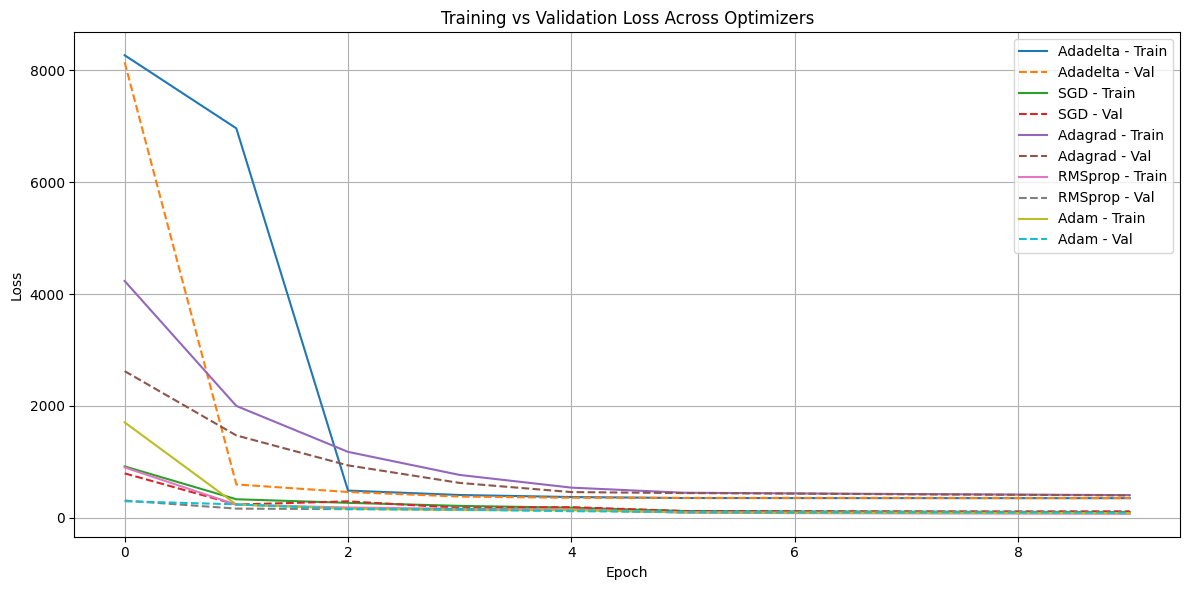

In [29]:
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'{list(optimizers.keys())[i]} - Train')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'{list(optimizers.keys())[i]} - Val')
plt.title('Training vs Validation Loss Across Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

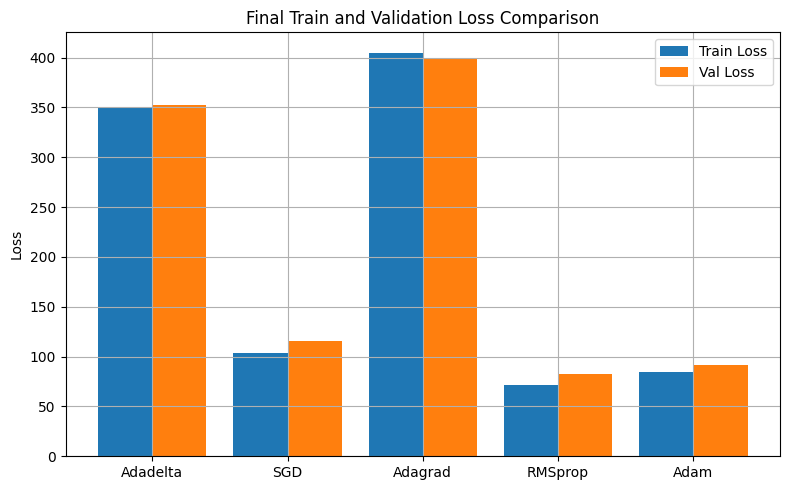

In [30]:
# === 2. Final Training and Validation Losses Comparison ===
final_train_losses = [h.history['loss'][-1] for h in histories]
final_val_losses = [h.history['val_loss'][-1] for h in histories]
optimizer_names = list(optimizers.keys())

x = range(len(optimizer_names))
plt.figure(figsize=(8, 5))
plt.bar(x, final_train_losses, width=0.4, label='Train Loss', align='center')
plt.bar([i + 0.4 for i in x], final_val_losses, width=0.4, label='Val Loss', align='center')
plt.xticks([i + 0.2 for i in x], optimizer_names)
plt.title('Final Train and Validation Loss Comparison')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:1447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.plot_data[axis] = cat_data


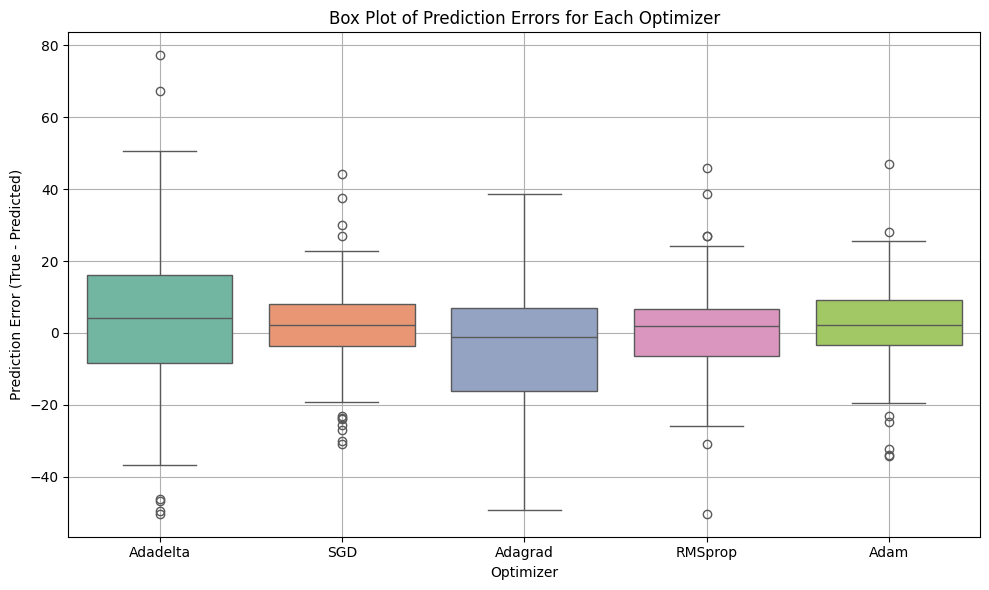

In [31]:
# Collect prediction errors for each optimizer
errors_by_optimizer = {name: [] for name in optimizers.keys()}

for name, model in zip(optimizers.keys(), models):
    rul_pred = model.predict(processed_test_data).reshape(-1)
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [
        np.average(engine_preds, weights=np.repeat(1/len(engine_preds), len(engine_preds)))
        for engine_preds in preds_for_each_engine
    ]
    error_for_engine = np.array(mean_pred_for_each_engine) - np.array(true_rul)

    # Store errors for each optimizer
    errors_by_optimizer[name] = error_for_engine

# Create a DataFrame for easier plotting with seaborn
error_df = pd.DataFrame(errors_by_optimizer)

# Plot Box Plot for error distribution across optimizers
plt.figure(figsize=(10, 6))
sns.boxplot(data=error_df, palette='Set2')
plt.title('Box Plot of Prediction Errors for Each Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Prediction Error (True - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.savefig("boxplot_prediction_errors_by_optimizer.png")
plt.show()


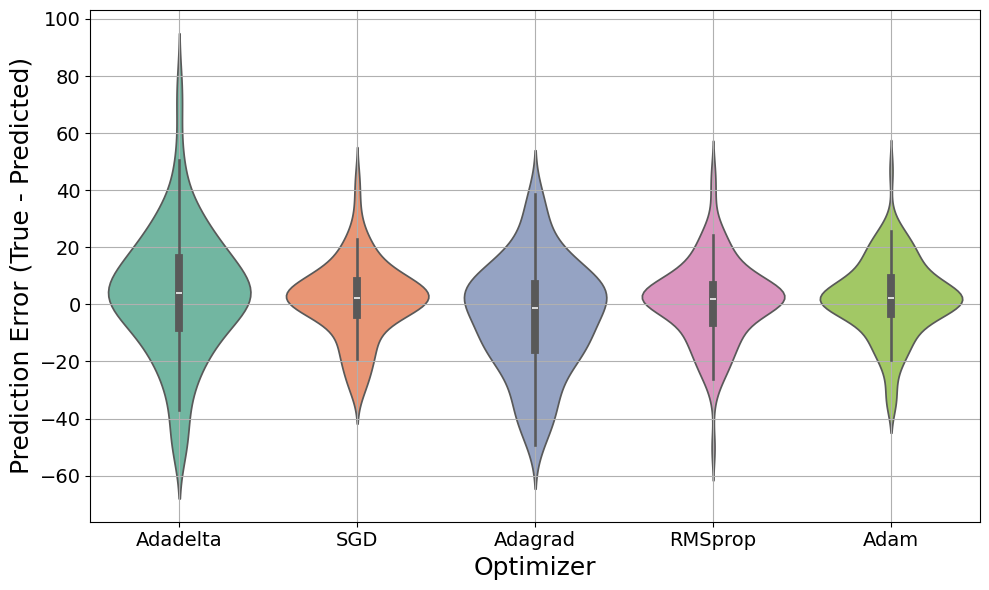

In [32]:
# Plot Violin Plot for error distribution across optimizers
plt.figure(figsize=(10, 6))
sns.violinplot(data=error_df, palette='Set2')
plt.xlabel('Optimizer' , fontsize=18)
plt.ylabel('Prediction Error (True - Predicted)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("violinplot_prediction_errors_by_optimizer.png")
plt.show()


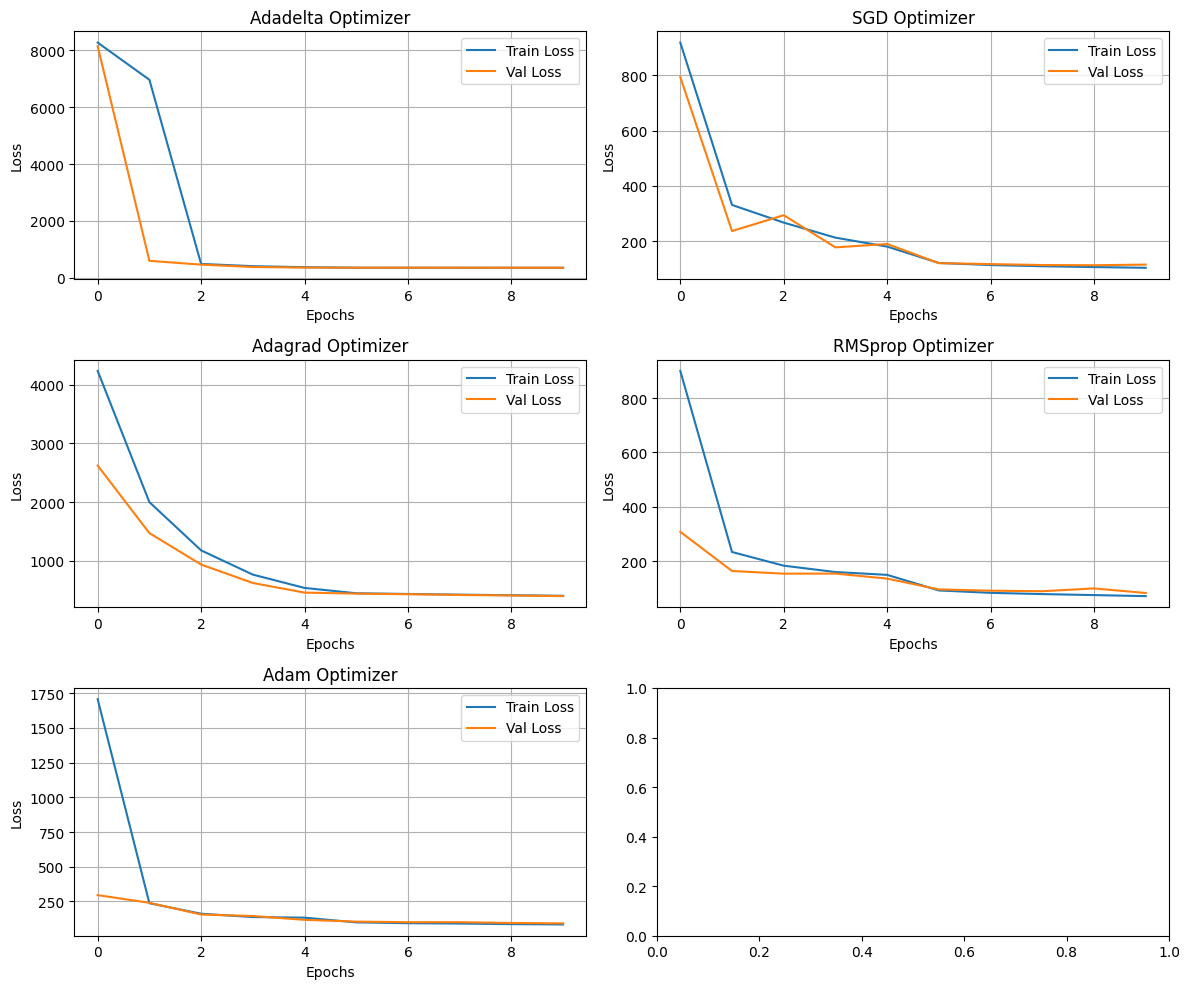

In [33]:
# === 4. Learning Curve (Train and Val Loss Together per Optimizer) ===
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.ravel()
for i, history in enumerate(histories):
    axs[i].plot(history.history['loss'], label='Train Loss')
    axs[i].plot(history.history['val_loss'], label='Val Loss')
    axs[i].set_title(f'{optimizer_names[i]} Optimizer')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()
    axs[i].grid(True)
plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


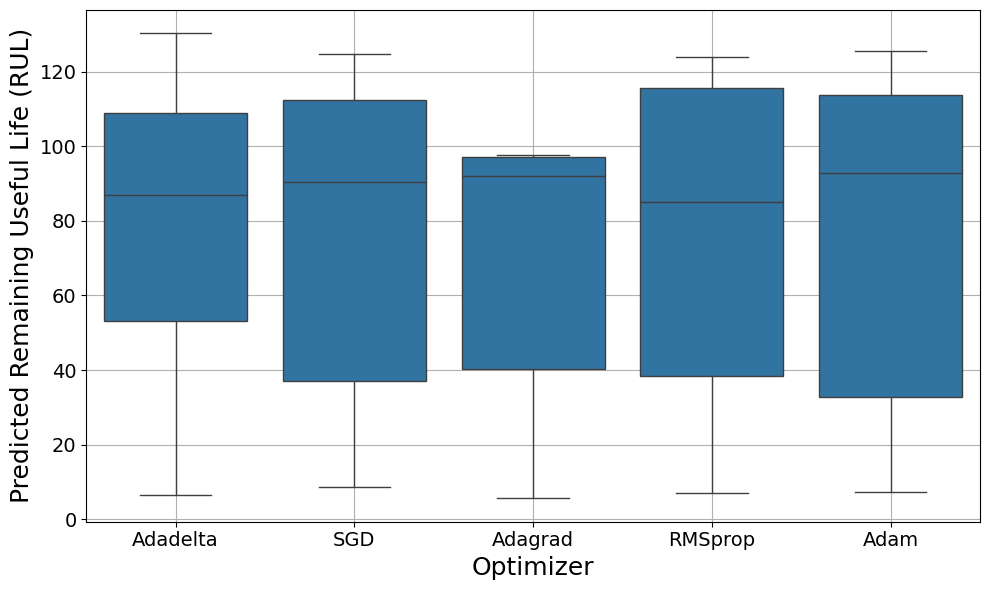

In [34]:
all_preds = []  # to store all preds for boxplot
for name, model in zip(optimizers.keys(), models):
    rul_pred = model.predict(processed_test_data).reshape(-1)
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [
        np.average(engine_preds, weights=np.repeat(1/len(engine_preds), len(engine_preds)))
        for engine_preds in preds_for_each_engine
    ]
    for pred in mean_pred_for_each_engine:
        all_preds.append({"Optimizer": name, "Predicted RUL": pred})

import pandas as pd
df_preds = pd.DataFrame(all_preds)
df_preds["True RUL"] = list(true_rul) * len(optimizers)

plt.figure(figsize=(10, 6))
sns.boxplot(x="Optimizer", y="Predicted RUL", data=df_preds)

# Set titles and labels with increased font sizes
# plt.title("Box Plot Comparison of RUL Predictions by Optimizers", fontsize=16)
plt.xlabel("Optimizer", fontsize=18)
plt.ylabel("Predicted Remaining Useful Life (RUL)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
import plotly.express as px

fig = px.bar(
    x=optimizer_names,
    y=rmses,
    labels={'x': 'Optimizer', 'y': 'RMSE'},
    title="Interactive RMSE on Test Set Across Optimizers",
    text=rmses
)
fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


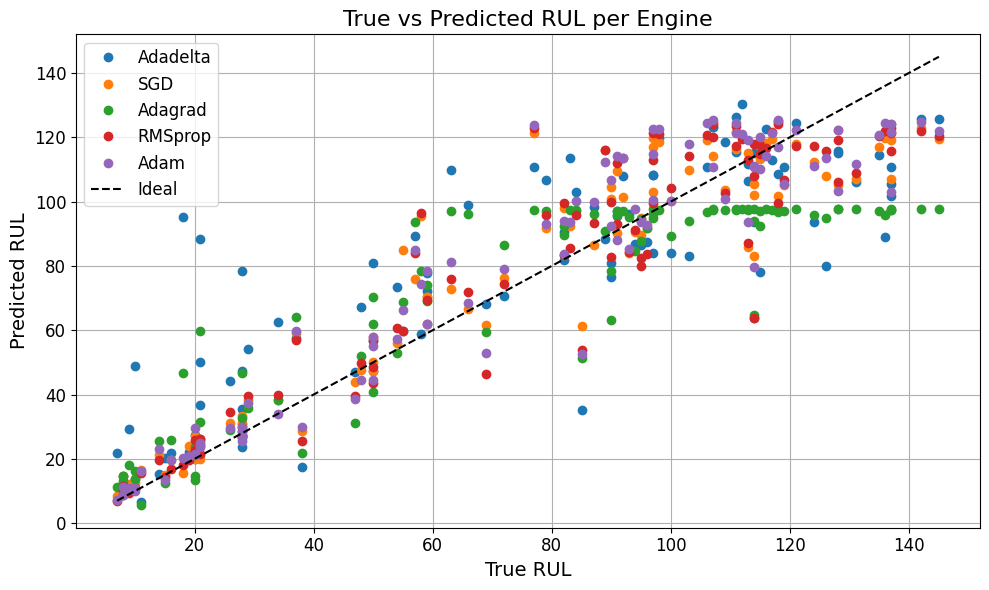

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, model in enumerate(models):
    rul_pred = model.predict(processed_test_data).reshape(-1)
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [
        np.average(engine_preds, weights=np.repeat(1/len(engine_preds), len(engine_preds)))
        for engine_preds in preds_for_each_engine
    ]
    ax.plot(true_rul, mean_pred_for_each_engine, 'o', label=f'{list(optimizers.keys())[i]}')

ax.plot([min(true_rul), max(true_rul)], [min(true_rul), max(true_rul)], 'k--', label='Ideal')

ax.set_xlabel("True RUL", fontsize=14)
ax.set_ylabel("Predicted RUL", fontsize=14)
ax.set_title("True vs Predicted RUL per Engine", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.savefig("true_vs_predicted_rul_per_engine.png")
plt.show()


In [37]:
import plotly.graph_objs as go

fig = go.Figure()
for i, history in enumerate(histories):
    fig.add_trace(go.Scatter(
        y=history.history['loss'],
        mode='lines',
        name=f'{list(optimizers.keys())[i]} - Train'
    ))
    fig.add_trace(go.Scatter(
        y=history.history['val_loss'],
        mode='lines',
        name=f'{list(optimizers.keys())[i]} - Val',
        line=dict(dash='dash')
    ))

fig.update_layout(
    title='Interactive Training & Validation Loss Across Optimizers',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    hovermode='x unified'
)
fig.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


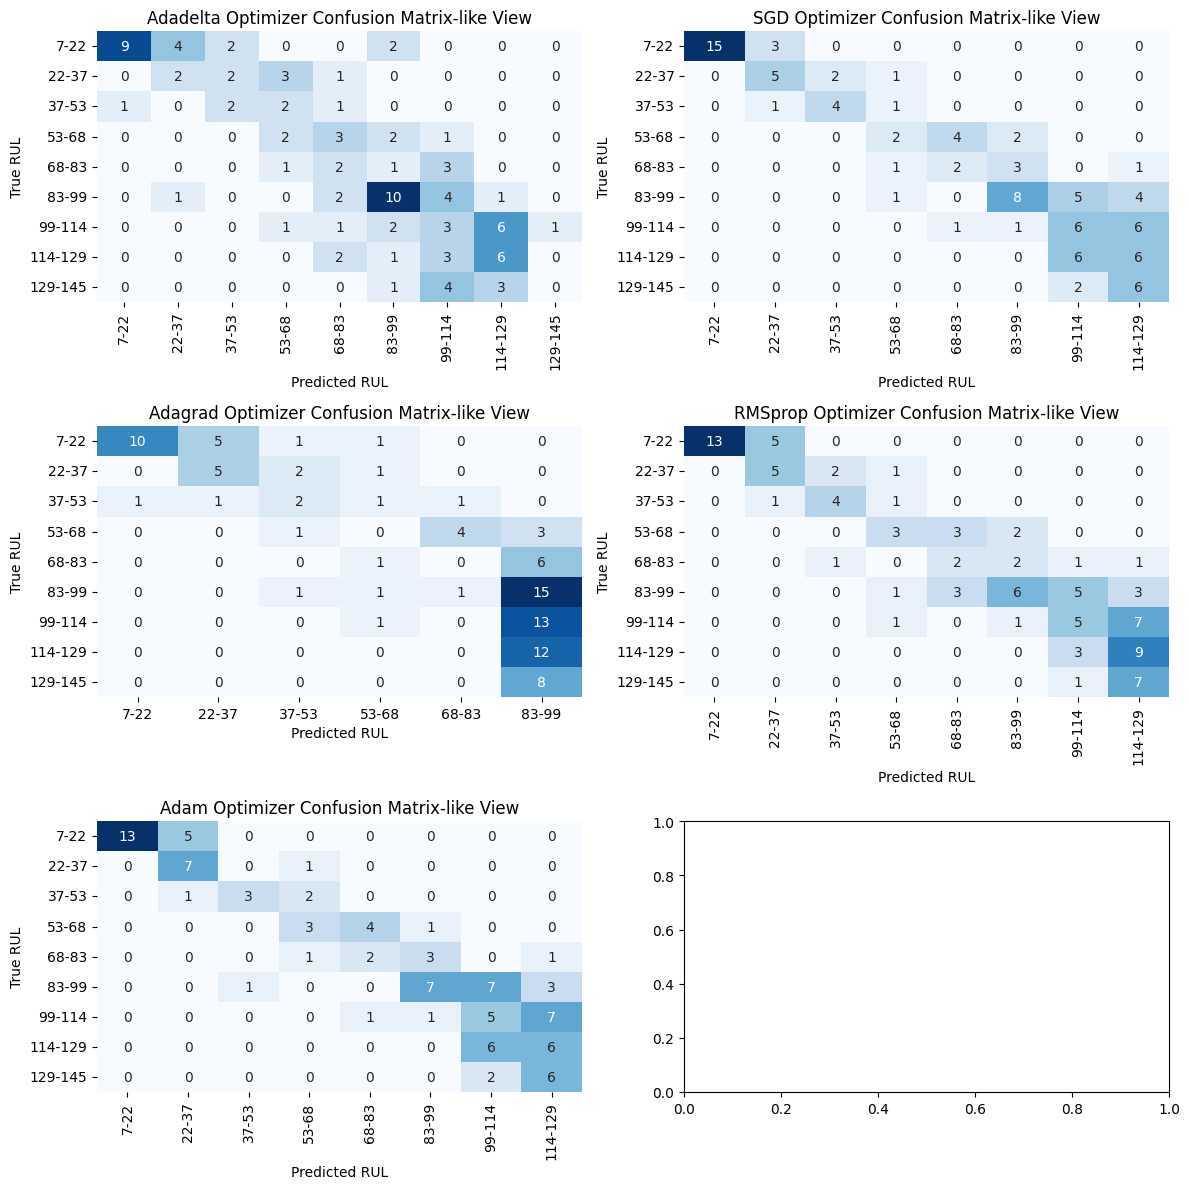

In [38]:
import numpy as np
import seaborn as sns
import pandas as pd

# Define RUL bins
rul_bins = np.linspace(min(true_rul), max(true_rul), 10)  # Adjust number of bins as needed
bin_labels = [f"{int(rul_bins[i])}-{int(rul_bins[i+1])}" for i in range(len(rul_bins)-1)]

# Calculate confusion-like matrix for each optimizer
confusion_matrices = {}
for name, model in zip(optimizers.keys(), models):
    rul_pred = model.predict(processed_test_data).reshape(-1)
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [
        np.average(engine_preds, weights=np.repeat(1/len(engine_preds), len(engine_preds)))
        for engine_preds in preds_for_each_engine
    ]

    # Bin predictions and true RUL values
    true_binned = pd.cut(true_rul, bins=rul_bins, labels=bin_labels)
    pred_binned = pd.cut(mean_pred_for_each_engine, bins=rul_bins, labels=bin_labels)

    # Create confusion matrix
    confusion_matrix = pd.crosstab(true_binned, pred_binned, rownames=['True RUL'], colnames=['Predicted RUL'])
    confusion_matrices[name] = confusion_matrix

# Plot confusion matrix for each optimizer
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.ravel()
for i, (name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[i], cbar=False)
    axs[i].set_title(f'{name} Optimizer Confusion Matrix-like View')
plt.tight_layout()
plt.savefig("confusion_matrix_rul.png")
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


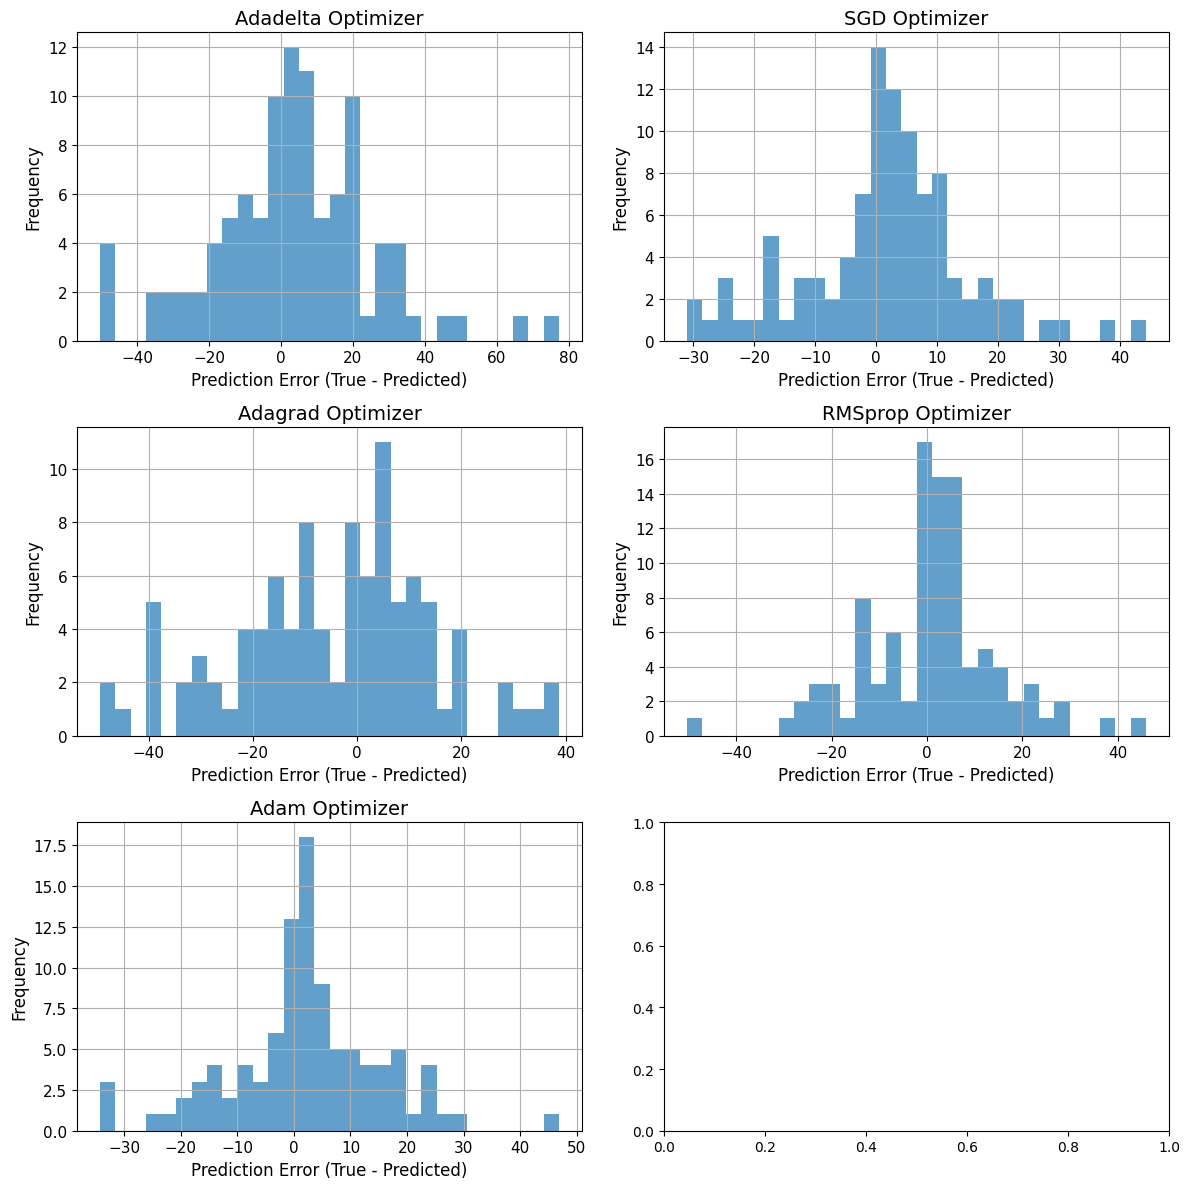

In [39]:
# Calculate errors
errors = []
for name, model in zip(optimizers.keys(), models):
    rul_pred = model.predict(processed_test_data).reshape(-1)
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [
        np.average(engine_preds, weights=np.repeat(1/len(engine_preds), len(engine_preds)))
        for engine_preds in preds_for_each_engine
    ]
    error_for_engine = np.array(mean_pred_for_each_engine) - np.array(true_rul)
    errors.append({"Optimizer": name, "Error": error_for_engine})

# Convert to DataFrame for easy plotting
df_errors = pd.DataFrame(errors)

# Plot histograms for each optimizer
# Plot histograms for each optimizer
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.ravel()
for i, error_data in enumerate(df_errors['Error']):
    axs[i].hist(error_data, bins=30, alpha=0.7)
    axs[i].set_title(f'{list(optimizers.keys())[i]} Optimizer', fontsize=14)
    axs[i].set_xlabel('Prediction Error (True - Predicted)', fontsize=12)
    axs[i].set_ylabel('Frequency', fontsize=12)
    axs[i].tick_params(axis='both', which='major', labelsize=11)
    axs[i].grid(True)

plt.tight_layout()
# plt.savefig("error_histograms.png")
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/tmp/ipython-input-3411983939.py:17: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




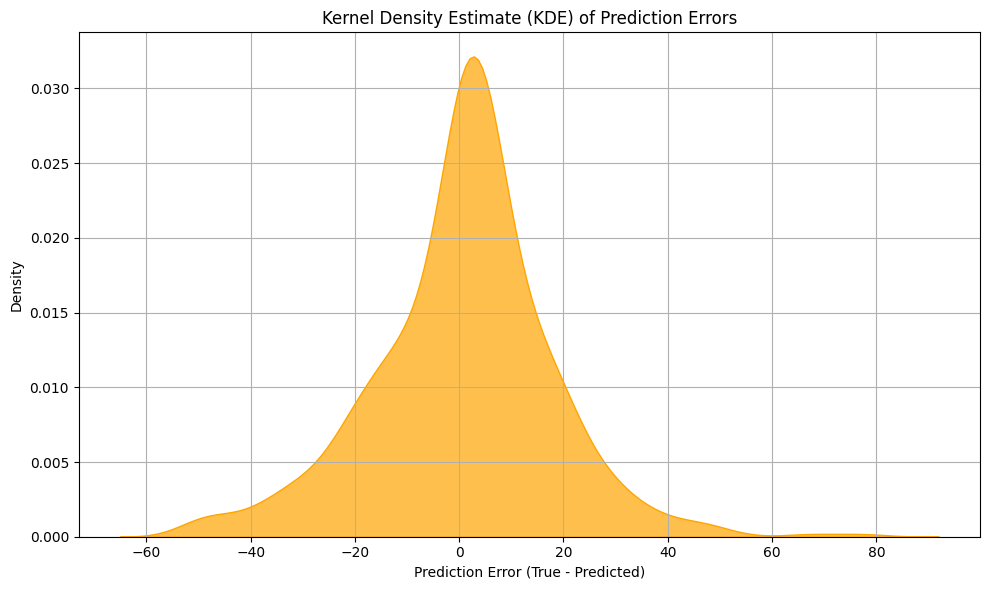

In [40]:
import seaborn as sns

# Combine errors into a single list for KDE plotting
all_errors = []
for name, model in zip(optimizers.keys(), models):
    rul_pred = model.predict(processed_test_data).reshape(-1)
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [
        np.average(engine_preds, weights=np.repeat(1/len(engine_preds), len(engine_preds)))
        for engine_preds in preds_for_each_engine
    ]
    error_for_engine = np.array(mean_pred_for_each_engine) - np.array(true_rul)
    all_errors.extend(error_for_engine)

# Plot KDE for error distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(all_errors, shade=True, color="orange", alpha=0.7)
plt.title('Kernel Density Estimate (KDE) of Prediction Errors')
plt.xlabel('Prediction Error (True - Predicted)')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.savefig("kde_prediction_errors.png")
plt.show()


In [41]:
import plotly.graph_objs as go

# Create interactive scatter plot for each optimizer
fig = go.Figure()

for i, model in enumerate(models):
    rul_pred = model.predict(processed_test_data).reshape(-1)
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [
        np.average(engine_preds, weights=np.repeat(1/len(engine_preds), len(engine_preds)))
        for engine_preds in preds_for_each_engine
    ]
    error_for_engine = np.array(mean_pred_for_each_engine) - np.array(true_rul)

    fig.add_trace(go.Scatter(
        x=np.arange(len(error_for_engine)),
        y=error_for_engine,
        mode='markers',
        name=f'{list(optimizers.keys())[i]} Optimizer',
        marker=dict(size=6, opacity=0.7),
        text=error_for_engine
    ))

fig.update_layout(
    title="Interactive Prediction Errors Over Time",
    xaxis_title="Sample Index",
    yaxis_title="Prediction Error (True - Predicted)",
    hovermode='x unified'
)
fig.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


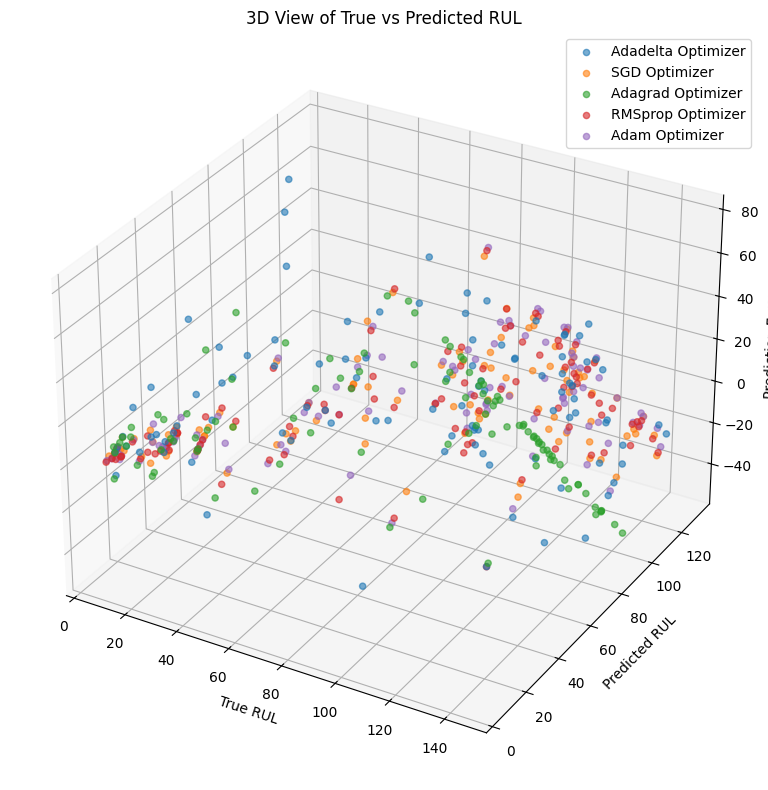

In [42]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i, model in enumerate(models):
    rul_pred = model.predict(processed_test_data).reshape(-1)
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [
        np.average(engine_preds, weights=np.repeat(1/len(engine_preds), len(engine_preds)))
        for engine_preds in preds_for_each_engine
    ]
    error_for_engine = np.array(mean_pred_for_each_engine) - np.array(true_rul)

    ax.scatter(true_rul, mean_pred_for_each_engine, error_for_engine, label=f'{list(optimizers.keys())[i]} Optimizer', alpha=0.6)

ax.set_xlabel('True RUL')
ax.set_ylabel('Predicted RUL')
ax.set_zlabel('Prediction Error')
ax.set_title('3D View of True vs Predicted RUL')
ax.legend()
plt.tight_layout()
plt.savefig("3d_true_vs_predicted_rul.png")
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

/tmp/ipython-input-3437534015.py:14: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/tmp/ipython-input-3437534015.py:14: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/tmp/ipython-input-3437534015.py:14: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/tmp/ipython-input-3437534015.py:14: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/tmp/ipython-input-3437534015.py:14: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




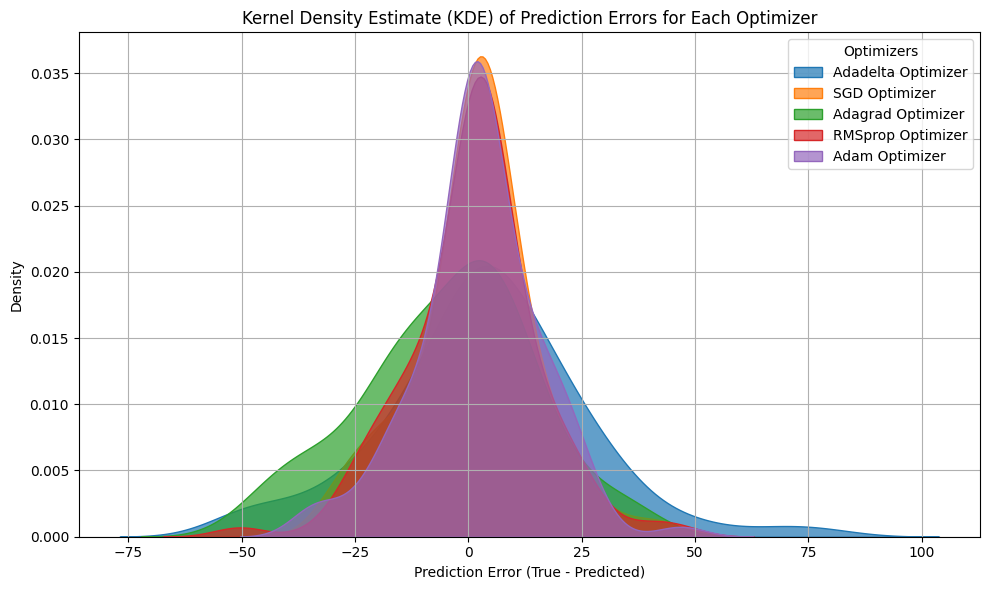

In [43]:
# Plot KDE for prediction errors for each optimizer separately
plt.figure(figsize=(10, 6))

for name, model in zip(optimizers.keys(), models):
    rul_pred = model.predict(processed_test_data).reshape(-1)
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [
        np.average(engine_preds, weights=np.repeat(1/len(engine_preds), len(engine_preds)))
        for engine_preds in preds_for_each_engine
    ]
    error_for_engine = np.array(mean_pred_for_each_engine) - np.array(true_rul)

    # Plot KDE for each optimizer's errors
    sns.kdeplot(error_for_engine, shade=True, label=f"{name} Optimizer", alpha=0.7)

plt.title('Kernel Density Estimate (KDE) of Prediction Errors for Each Optimizer')
plt.xlabel('Prediction Error (True - Predicted)', )
plt.ylabel('Density')
plt.legend(title="Optimizers")
plt.grid(True)
plt.tight_layout()
# plt.savefig("kde_prediction_errors_by_optimizer.png")
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


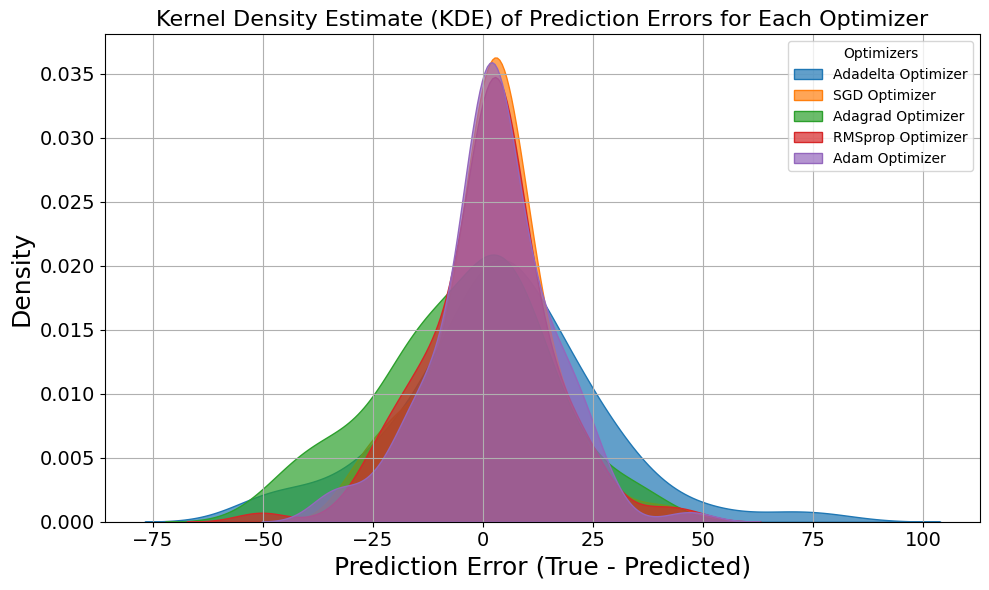

In [44]:
# Plot KDE for prediction errors for each optimizer separately
plt.figure(figsize=(10, 6))

for name, model in zip(optimizers.keys(), models):
    rul_pred = model.predict(processed_test_data).reshape(-1)
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [
        np.average(engine_preds, weights=np.repeat(1/len(engine_preds), len(engine_preds)))
        for engine_preds in preds_for_each_engine
    ]
    error_for_engine = np.array(mean_pred_for_each_engine) - np.array(true_rul)

    # Updated: use `fill=True` instead of deprecated `shade=True`
    sns.kdeplot(error_for_engine, fill=True, label=f"{name} Optimizer", alpha=0.7)

plt.title('Kernel Density Estimate (KDE) of Prediction Errors for Each Optimizer',fontsize = 16)
plt.xlabel('Prediction Error (True - Predicted)', fontsize = 18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title="Optimizers")
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
models[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 128)        │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 8, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │        25,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,033,013 (3.94 MB)

 Trainable params: 344,337 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 688,676 (2.63 MB)

In [46]:
# tf.keras.utils.plot_model(models[0], to_file="model_graphviz.png", show_shapes=True)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


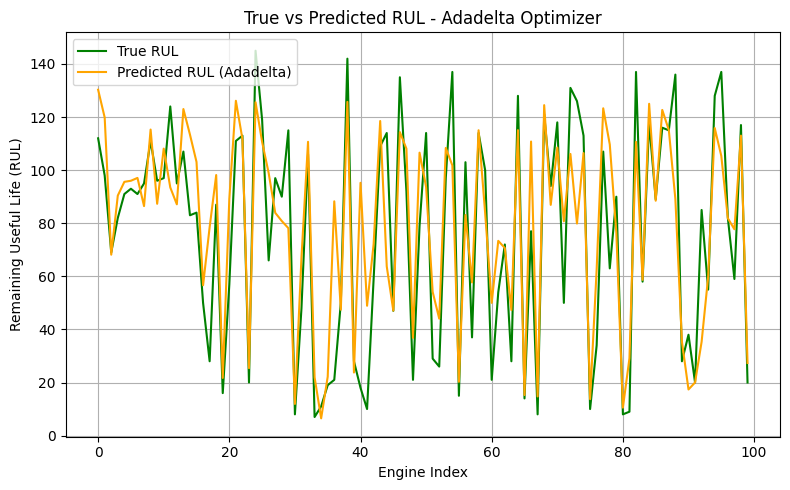

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


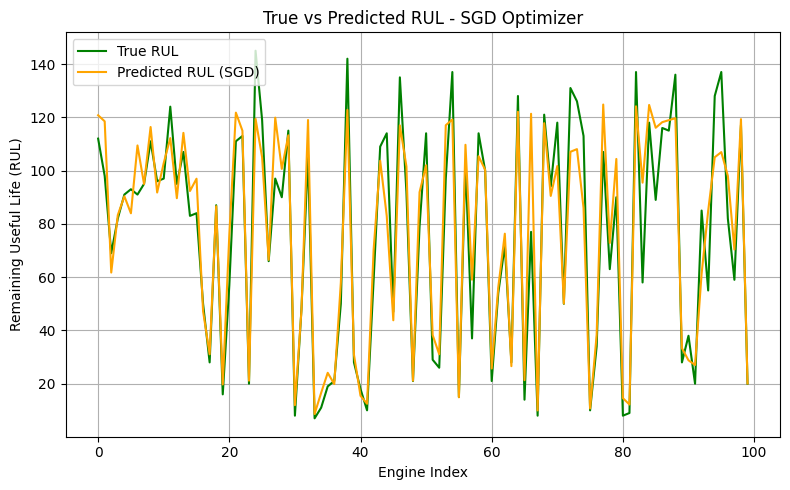

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


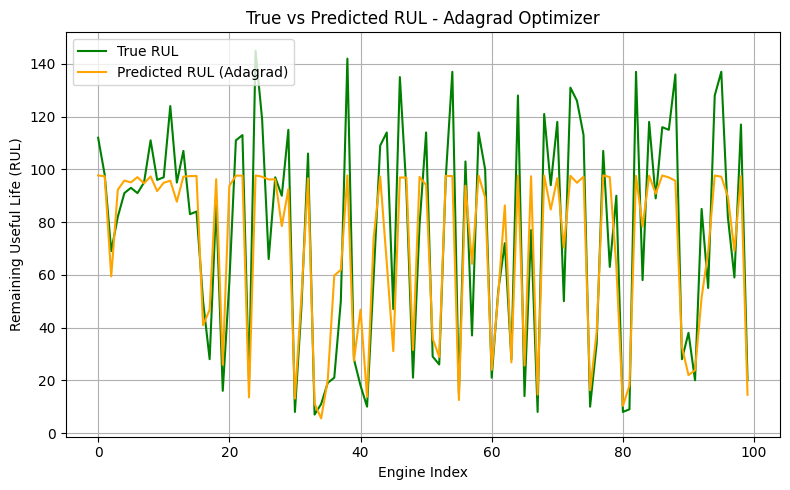

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


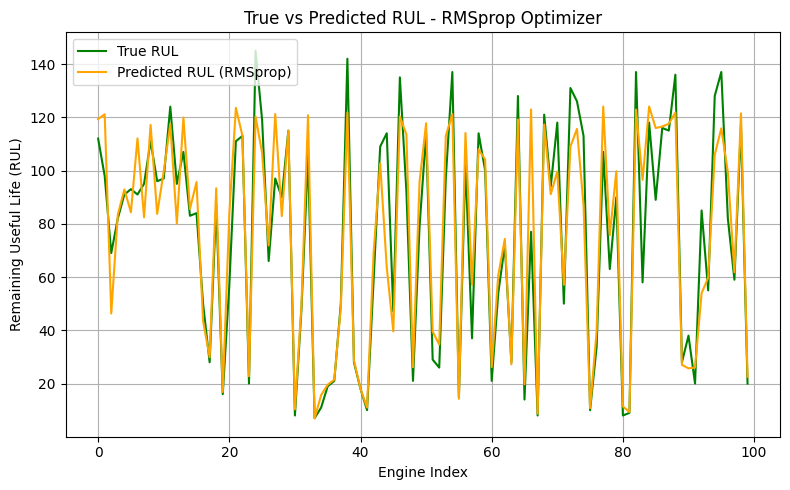

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


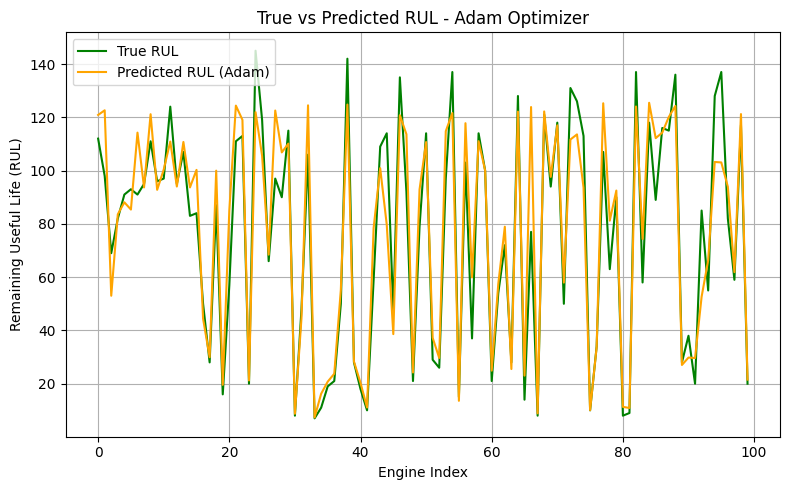

In [47]:
import matplotlib.pyplot as plt
import numpy as np

for i, model in enumerate(models):
    plt.figure(figsize=(8, 5))

    # Predict RUL
    rul_pred = model.predict(processed_test_data).reshape(-1)

    # Split predictions for each engine
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])

    # Weighted average of predictions
    mean_pred_for_each_engine = [
        np.average(engine_preds) if len(engine_preds) > 0 else 0
        for engine_preds in preds_for_each_engine
    ]

    # Plot true vs predicted RUL
    plt.plot(true_rul, label='True RUL', color='green')
    plt.plot(mean_pred_for_each_engine, label=f'Predicted RUL ({list(optimizers.keys())[i]})', color='orange')

    plt.title(f'True vs Predicted RUL - {list(optimizers.keys())[i]} Optimizer')
    plt.xlabel('Engine Index')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"true_vs_predicted_rul_{list(optimizers.keys())[i]}.png")
    plt.show()


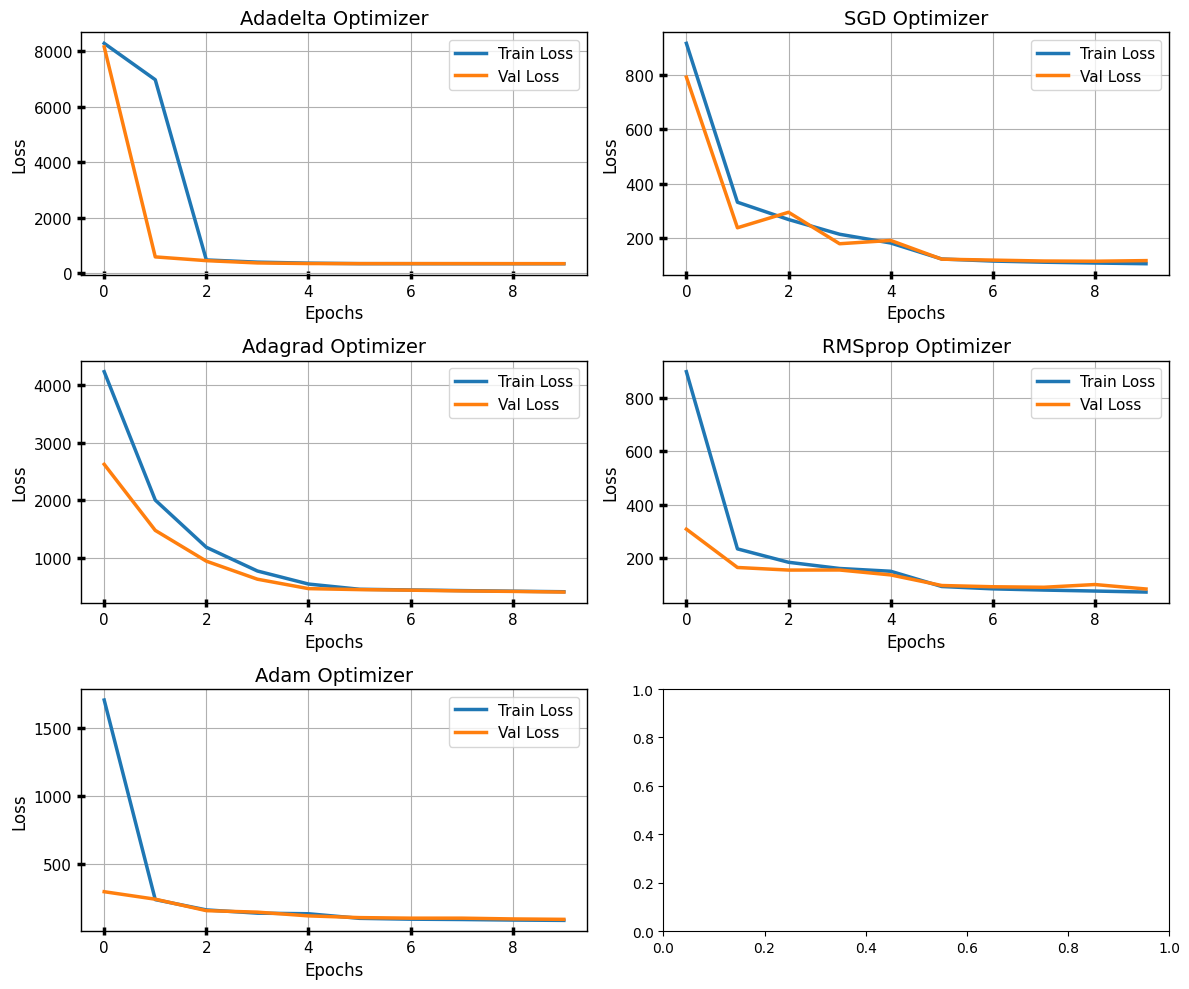

In [48]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.ravel()

for i, history in enumerate(histories):
    axs[i].plot(history.history['loss'], label='Train Loss', linewidth=2.5)
    axs[i].plot(history.history['val_loss'], label='Val Loss', linewidth=2.5)

    axs[i].set_title(f'{optimizer_names[i]} Optimizer', fontsize=14)
    axs[i].set_xlabel('Epochs', fontsize=12)
    axs[i].set_ylabel('Loss', fontsize=12)

    # Highlight internal axes (tick lines)
    axs[i].tick_params(
        axis='both',        # apply to both x and y
        width=2.5,          # thickness of tick lines
        length=6,           # length of tick lines
        direction='inout',  # ticks go both in and out for emphasis
        labelsize=11
    )

    # Leave outer spines thin
    axs[i].spines['top'].set_linewidth(1)
    axs[i].spines['right'].set_linewidth(1)
    axs[i].spines['bottom'].set_linewidth(1)
    axs[i].spines['left'].set_linewidth(1)

    axs[i].legend(fontsize=11)
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [49]:
for model, name in zip(models, optimizer_names):
    model.save(f'model_{name}.keras')


In [50]:
models[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 128)        │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 8, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │        25,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,033,013 (3.94 MB)

 Trainable params: 344,337 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 688,676 (2.63 MB)

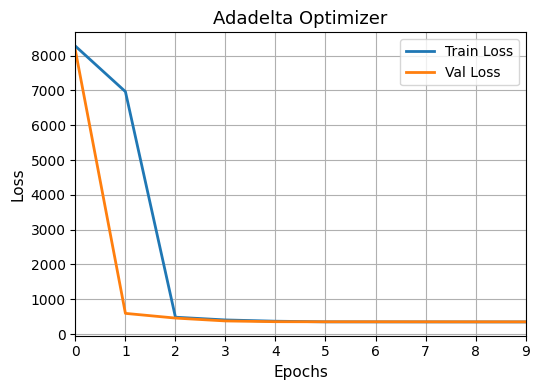

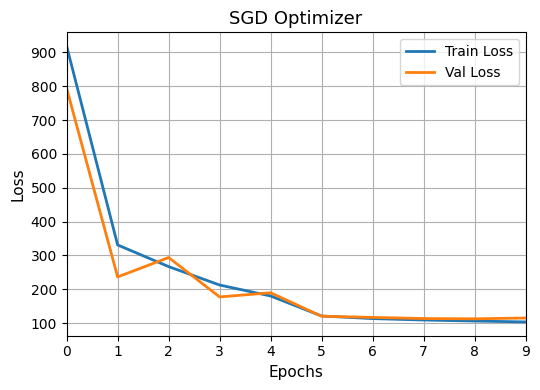

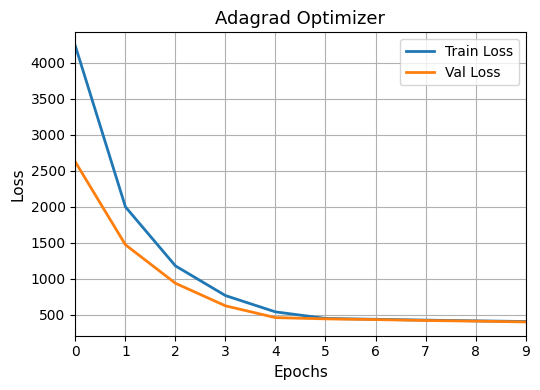

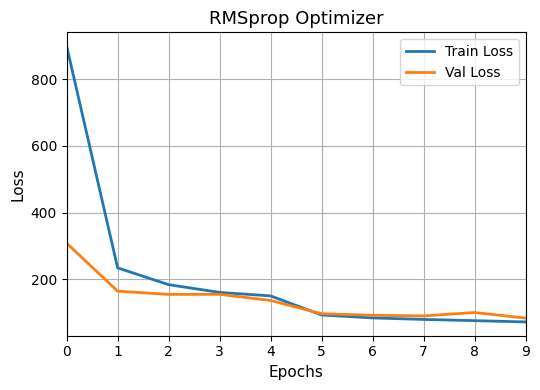

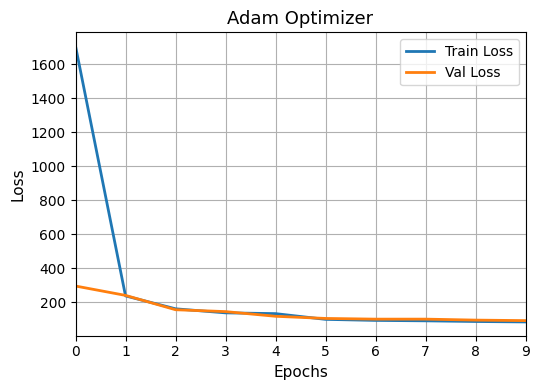

In [51]:
for i, history in enumerate(histories):
    epochs = len(history.history['loss'])
    plt.figure(figsize=(5.5, 4))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    plt.title(f'{optimizer_names[i]} Optimizer', fontsize=13)
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Loss', fontsize=11)
    plt.xticks(range(epochs))
    plt.xlim(0, epochs - 1)  # Fix start and end of x-axis
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [52]:
import plotly.graph_objs as go

for i, model in enumerate(models):
    rul_pred = model.predict(processed_test_data).reshape(-1)
    preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
    mean_pred_for_each_engine = [
        np.average(engine_preds) if len(engine_preds) > 0 else 0
        for engine_preds in preds_for_each_engine
    ]

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y=true_rul,
        mode='lines',
        name='True RUL',
        line=dict(color='green', width=1.5)
    ))

    fig.add_trace(go.Scatter(
        y=mean_pred_for_each_engine,
        mode='lines',
        name=f'Predicted RUL ({list(optimizers.keys())[i]})',
        line=dict(color='red', width=1.5)
    ))

    fig.update_layout(
        title={
            'text': f'{list(optimizers.keys())[i]} Optimizer',
            'x': 0.1,
            'xanchor': 'left',
            'font': dict(size=18)
        },
        width=700,
        height=350,
        xaxis=dict(
            title='Engine Index',
            title_font=dict(size=18),
            tickfont=dict(size=13),
            tickmode='linear',
            tick0=0,
            dtick=10,
            range=[0, 100]
        ),
        yaxis=dict(
            title='Remaining Useful Life (RUL)',
            title_font=dict(size=18),
            tickfont=dict(size=13)
        ),
        showlegend=False,
        hovermode='x unified',
        margin=dict(t=60, r=30, b=50, l=60),
    )

    fig.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [53]:
models[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 128)        │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 8, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │        25,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,033,013 (3.94 MB)

 Trainable params: 344,337 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 688,676 (2.63 MB)